In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import pandas as pd
import cv2
import xarray as xr
from utils.aux_funcs import find
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage.exposure import adjust_gamma
import matplotlib as mpl
import matplotlib
import matplotlib.patches as mpatches

In [2]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams.update({'font.size': 18})

In [3]:
def pack_video_frames(video_path, dwsmpl=1):
    # open the .avi file
    vidread = cv2.VideoCapture(video_path)
    # empty array that is the target shape
    # should be number of frames x downsampled height x downsampled width
    all_frames = np.empty([int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)),
                        int(vidread.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                        int(vidread.get(cv2.CAP_PROP_FRAME_WIDTH))], dtype=np.uint8)
    # iterate through each frame
    for frame_num in tqdm(range(0,int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)))):
        # read the frame in and make sure it is read in correctly
        ret, frame = vidread.read()
        if not ret:
            break
        # convert to grayyscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # downsample the frame by an amount specified in the config file
        sframe = cv2.resize(frame, (0,0), fx=dwsmpl, fy=dwsmpl, interpolation=cv2.INTER_NEAREST)
        # add the downsampled frame to all_frames as int8
        all_frames[frame_num,:,:] = sframe.astype(np.int8)
    return all_frames

In [4]:
start = 1496 # sec
base = 'fm1'
recording_path = os.path.join('/home/niell_lab/data/freely_moving_ephys/ephys_recordings/070921/J553RT/', base)
probe = 'DB_P128-6'
vidfile = '/home/niell_lab/Desktop/070921_J553RT_'+base+'.mp4'
audfile = '/home/niell_lab/Desktop/070921_J553RT_'+base+'.wav'
merge_mp4_name = '/home/niell_lab/Desktop/070921_J553RT_'+base+'_merge.mp4'
has_top = (False if 'hf' in base else True)
population_pickle_path = '/home/niell_lab/data/freely_moving_ephys/batch_files/120221_hffm/pooled_ephys_population_update_120621.pickle'
session_name = '070921_J553RT_control_Rig2'

ephys_h5 = pd.read_hdf(find('*ephys*.h5', recording_path)[0])
world_nc = xr.open_dataset(find('*world*.nc', recording_path)[0])
eye_nc = xr.open_dataset(find('*REYE*.nc', recording_path)[0])
top_nc = xr.open_dataset(find('*TOP1*.nc', recording_path)[0])
eye_avi_path = find('*REYEdeinter.avi', recording_path)[0]
imu_data = xr.open_dataset(find('*imu*.nc', recording_path)[0])
ephysT0 = pd.read_json(find('*_ephys_merge.json', recording_path)[0]).iloc[0,12]

print('ephys')
ephys_pickle = pd.read_pickle(population_pickle_path) ### NEED PICKLE PATH
pooled_ephys = ephys_pickle[ephys_pickle['session']==session_name] ### NEED SESSION KEY
del ephys_pickle

print('eye')
eye_params = eye_nc.REYE_ellipse_params
eyeT = eye_nc.timestamps - ephysT0
del eye_nc
eye = pack_video_frames(eye_avi_path).astype(np.uint8)[:,200:,120:500]

print('world')
worldT = world_nc.timestamps - ephysT0
world = world_nc.WORLD_video.astype(np.uint8)
del world_nc

print('top')
topT = top_nc.timestamps - ephysT0
top = top_nc.TOP1_video.astype(np.uint8)
del top_nc

th = eye_params.sel(ellipse_params='theta').values
longaxis = eye_params.sel(ellipse_params='longaxis')
del eye_params

gz = np.array(imu_data.IMU_data.sel(channel='gyro_z'))
accT = ephys_h5[base+'_accT'].iloc[0]
del imu_data

ephys
eye


100%|██████████████████████████████████████████████████████████████████████████████| 147790/147790 [01:16<00:00, 1937.90it/s]


world
top


In [5]:
start = 1497

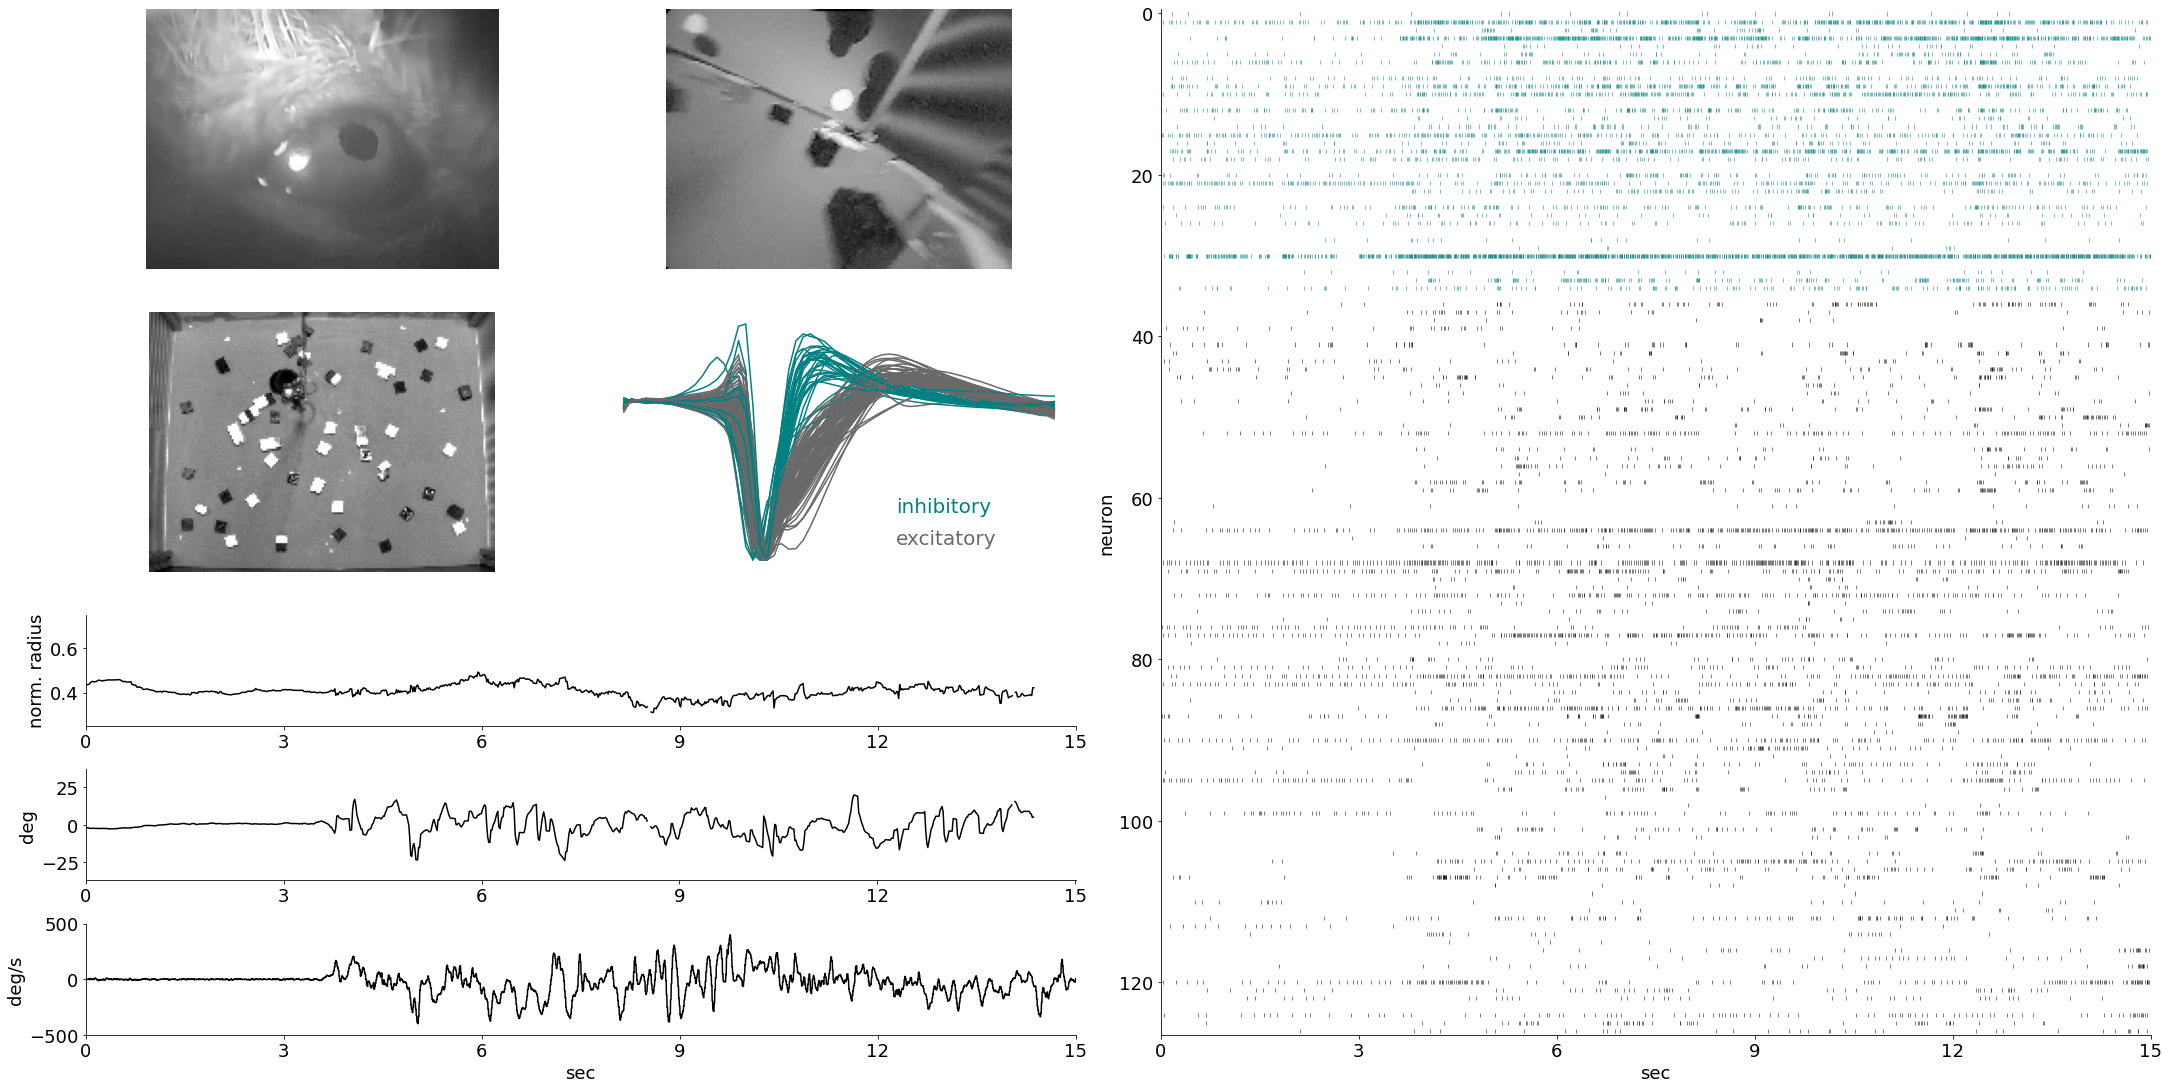

In [13]:
tr = [start, start+15]
t = np.mean(tr)

fig = plt.figure(constrained_layout=True, figsize=(30,15))
gs = fig.add_gridspec(7,4)
ax_eyecam = fig.add_subplot(gs[0:2,0])
ax_worldcam = fig.add_subplot(gs[0:2,1])
ax_topcam = fig.add_subplot(gs[2:4,0])
ax_celltype = fig.add_subplot(gs[2:4,1])
ax_theta = fig.add_subplot(gs[5,0:2])
ax_gyro_z = fig.add_subplot(gs[6,0:2])
ax_radius = fig.add_subplot(gs[4,0:2])
ax_raster = fig.add_subplot(gs[:,2:4])

for ind, row in pooled_ephys.iterrows():
    if row['exc_or_inh'] == 'inh':
        ax_celltype.plot(row['norm_waveform'], 'teal')
    elif row['exc_or_inh'] == 'exc':
        ax_celltype.plot(row['norm_waveform'], 'dimgray')
ax_celltype.axis('off')
ax_celltype.annotate('inhibitory', xy=[38,-0.7], color='teal', fontsize=20)
ax_celltype.annotate('excitatory', xy=[38,-0.9], color='dimgray', fontsize=20)
eyeFr = np.abs(eyeT-t).argmin(dim = "frame")
worldFr = np.abs(worldT-t).argmin(dim = "frame")
topFr = np.abs(topT-t).argmin(dim = "frame")

ax_eyecam.cla(); ax_eyecam.axis('off')
ax_eyecam.imshow(eye[eyeFr].astype(np.uint8), 'gray', vmin=0, vmax=255, aspect='equal')

ax_worldcam.cla(); ax_worldcam.axis('off')
ax_worldcam.imshow(world[worldFr].astype(np.uint8), 'gray', vmin=0, vmax=255, aspect='equal')

ax_topcam.cla(); ax_topcam.axis('off')
ax_topcam.imshow(top[topFr].astype(np.uint8), 'gray', vmin=0, vmax=255, aspect='equal')

th_start = np.abs(eyeT-tr[0]).argmin(dim='frame').values
th_stop = np.abs(eyeT-tr[1]).argmin(dim='frame').values
th_plot = th[th_start:th_stop]
th_plot = np.rad2deg(th_plot - np.nanmean(th_plot))

ax_theta.cla()
ax_theta.fontsize = 20
ax_theta.plot(eyeT[th_start:th_stop], th_plot, color='k')
ax_theta.set_xlim(eyeT[th_start], eyeT[th_stop])
ax_theta.set_ylabel('deg')
ax_theta.set_ylim([-37,37])
ax_theta.set_xticks(ticks=np.linspace(start, start+15, 6))
ax_theta.set_xticklabels(labels=np.linspace(0, 15, 6).astype(int))

ax_radius.cla()
ax_radius.fontsize = 20
ax_radius.plot(eyeT, longaxis/np.nanmax(longaxis), color='k')
ax_radius.set_xlim(tr[0], tr[1])
ax_radius.set_ylabel('norm. radius')
ax_radius.set_ylim([0.25,0.75])
ax_radius.set_xticks(ticks=np.linspace(start, start+15, 6))
ax_radius.set_xticklabels(labels=np.linspace(0, 15, 6).astype(int))

ax_gyro_z.cla()
ax_gyro_z.fontsize = 20
ax_gyro_z.plot(accT, gz, color='k')
ax_gyro_z.set_xlim(tr[0], tr[1])
ax_gyro_z.set_ylim(-500, 500)
ax_gyro_z.set_ylabel('deg/s')
ax_gyro_z.set_xticks(ticks=np.linspace(start, start+15, 6))
ax_gyro_z.set_xticklabels(labels=np.linspace(0, 15, 6).astype(int))
ax_gyro_z.set_xlabel('sec')

ax_raster.fontsize = 20
if '64' in probe:
    sh_num = 2
elif '128' in probe:
    sh_num = 4
inh_goodcells = pooled_ephys[pooled_ephys['exc_or_inh']=='inh']
sh0 = np.arange(0,len(inh_goodcells.index)+sh_num,sh_num)
inh_full_raster = np.array([]).astype(int)
for sh in range(sh_num):
    inh_full_raster = np.concatenate([inh_full_raster, sh0+sh])
for i, ind in enumerate(inh_goodcells.index):
    i = inh_full_raster[i]
    ax_raster.vlines(inh_goodcells.at[ind,'fm1_spikeT'],i-0.25,i+0.25,color='teal',linewidth=0.5)

exc_goodcells = pooled_ephys[pooled_ephys['exc_or_inh']=='exc']
sh0 = np.arange(0,len(exc_goodcells.index)+sh_num,sh_num)
exc_full_raster = np.array([]).astype(int)
for sh in range(sh_num):
    exc_full_raster = np.concatenate([exc_full_raster, sh0+sh])
for i, ind in enumerate(exc_goodcells.index):
    i = exc_full_raster[i] + np.size(inh_full_raster,0)
    ax_raster.vlines(exc_goodcells.at[ind,'fm1_spikeT'],i-0.25,i+0.25, color='k',linewidth=0.5)

n_units = len(exc_goodcells) + len(inh_goodcells)
ax_raster.set_ylim(n_units+0.5, -.5)
ax_raster.set_xlim(tr[0], tr[1])
ax_raster.set_xlabel('sec')
ax_raster.set_ylabel('neuron')
ax_raster.spines['right'].set_visible(False)
ax_raster.spines['top'].set_visible(False)
ax_raster.set_xticks(ticks=np.linspace(start, start+15, 6))
ax_raster.set_xticklabels(labels=np.linspace(0, 15, 6).astype(int))

fig.savefig('/home/niell_lab/Desktop/ephys_data_demo.pdf')

In [22]:
tr[0]

475

In [30]:
th_start = np.abs(eyeT-tr[0]).argmin(dim='frame').values
th_stop = np.abs(eyeT-tr[1]).argmin(dim='frame').values
print(th_start, th_stop)

25838 26657


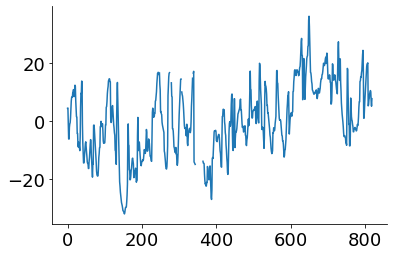

In [35]:
th_plot = th[th_start:th_stop]
th_plot = np.rad2deg(th_plot - np.nanmean(th_plot))
plt.plot(th_plot)

In [36]:
np.nanmin(th_plot)

-32.183661234538334

In [37]:
np.nanmax(th_plot)

36.23187293605848

In [21]:
eyeT[tr[1]].values

array(8.02513275)